In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
tf.random.set_seed(0)
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Load data
- set the load data row number
- set colunms names
- remove useless colunms

In [3]:
row_num = 30000
test_num= 4000
n_time_steps = 30
n_features = 9
n_epoch = 150

In [4]:
from ppl_util import DataUtil

In [5]:
path_list = ["data/DoS_dataset.csv","data/Fuzzy_dataset.csv","data/gear_dataset.csv",'data/RPM_dataset.csv',"data/normal_run_data.txt"]
data_util = DataUtil(n_row=row_num, path_list=path_list, n_time_step=n_time_steps, n_features=n_features)

In [6]:
dataset = data_util.read_files(is_shuffle=True)
dataset.head()

/home/laha/anaconda3/envs/tf_ppl/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,features,label
4826,"[[2, 0, 0, 0, 0, 0, 2, 14, 52], [1349, 216, 0,...",norm
431,"[[790, 5, 34, 96, 9, 34, 33, 0, 111], [399, 25...",dos
2824,"[[305, 14, 128, 0, 0, 51, 127, 4, 243], [320, ...",gear
3241,"[[1201, 0, 0, 0, 0, 0, 0, 0, 0], [497, 8, 0, 0...",rpm
3048,"[[672, 0, 0, 131, 29, 150, 2, 189, 0], [848, 5...",rpm


In [7]:
features, label = data_util.get_train_data()

In [8]:
features.shape

(4856, 30, 9)

In [9]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential

In [10]:
from tensorflow.keras.layers import Input,Conv1D,Dropout,MaxPooling1D,Flatten,Dense

In [11]:
divergence_fn = lambda q,p,_: tfd.kl_divergence(q,p)/features.shape[0]
def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

In [18]:
model = Sequential([
    tfpl.Convolution1DReparameterization(
    input_shape=(n_time_steps,n_features),filters=8, kernel_size=3,activation='relu',
    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
    kernel_divergence_fn = divergence_fn,
    bias_prior_fn = tfpl.default_multivariate_normal_fn,
    bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
    bias_divergence_fn =  divergence_fn   
    ),
    tfpl.Convolution1DReparameterization(
    filters=16, kernel_size=3,activation='relu',
    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
    kernel_divergence_fn = divergence_fn,
    bias_prior_fn = tfpl.default_multivariate_normal_fn,
    bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
    bias_divergence_fn =  divergence_fn   
    ),
    MaxPooling1D(16),
    Flatten(),
    tfpl.DenseReparameterization(
        units = tfpl.OneHotCategorical.params_size(5),activation=None,
        kernel_prior_fn = tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn = divergence_fn,
        bias_prior_fn = tfpl.default_multivariate_normal_fn,
        bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn =  divergence_fn   
    ),
    tfpl.OneHotCategorical(5)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_reparameterization_2  (None, 28, 8)             448       
_________________________________________________________________
conv1d_reparameterization_3  (None, 26, 16)            800       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 16)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_reparameterization_1 ( (None, 5)                 170       
_________________________________________________________________
one_hot_categorical_1 (OneHo multiple                  0         
Total params: 1,418
Trainable params: 1,418
Non-trainable params: 0
____________________________________________________

/home/laha/anaconda3/envs/tf_ppl/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [19]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
              optimizer='adam',
              metrics=['categorical_accuracy'],
              experimental_run_tf_function=False)

In [20]:
history = model.fit(features[:test_num], label[:test_num], epochs=n_epoch, batch_size=64,
                    validation_data=(features[test_num:], label[test_num:]))

Epoch 1/150
63/63 [==============================] - 1s 8ms/step - loss: 16.8865 - categorical_accuracy: 0.2033 - val_loss: 10.5122 - val_categorical_accuracy: 0.2033
Epoch 2/150
63/63 [==============================] - 0s 4ms/step - loss: 9.2582 - categorical_accuracy: 0.2105 - val_loss: 6.1474 - val_categorical_accuracy: 0.2231
Epoch 3/150
63/63 [==============================] - 0s 6ms/step - loss: 5.2060 - categorical_accuracy: 0.2105 - val_loss: 4.7809 - val_categorical_accuracy: 0.2138
Epoch 4/150
63/63 [==============================] - 0s 5ms/step - loss: 4.2144 - categorical_accuracy: 0.2055 - val_loss: 3.1498 - val_categorical_accuracy: 0.2126
Epoch 5/150
63/63 [==============================] - 0s 4ms/step - loss: 3.0467 - categorical_accuracy: 0.1982 - val_loss: 2.5728 - val_categorical_accuracy: 0.2079
Epoch 6/150
63/63 [==============================] - 0s 5ms/step - loss: 2.6380 - categorical_accuracy: 0.2000 - val_loss: 2.5998 - val_categorical_accuracy: 0.1916
Epoch 7/

63/63 [==============================] - 0s 6ms/step - loss: 1.8315 - categorical_accuracy: 0.2670 - val_loss: 1.8476 - val_categorical_accuracy: 0.2617
Epoch 51/150
63/63 [==============================] - 0s 5ms/step - loss: 1.8275 - categorical_accuracy: 0.2715 - val_loss: 1.8519 - val_categorical_accuracy: 0.2932
Epoch 52/150
63/63 [==============================] - 0s 5ms/step - loss: 1.8317 - categorical_accuracy: 0.2673 - val_loss: 1.8538 - val_categorical_accuracy: 0.2558
Epoch 53/150
63/63 [==============================] - 0s 5ms/step - loss: 1.8206 - categorical_accuracy: 0.2603 - val_loss: 1.8511 - val_categorical_accuracy: 0.2617
Epoch 54/150
63/63 [==============================] - 0s 7ms/step - loss: 1.8189 - categorical_accuracy: 0.2735 - val_loss: 1.8414 - val_categorical_accuracy: 0.2582
Epoch 55/150
63/63 [==============================] - 0s 6ms/step - loss: 1.8152 - categorical_accuracy: 0.2700 - val_loss: 1.8501 - val_categorical_accuracy: 0.2722
Epoch 56/150
63/6

63/63 [==============================] - 0s 7ms/step - loss: 1.7780 - categorical_accuracy: 0.2725 - val_loss: 1.8212 - val_categorical_accuracy: 0.2547
Epoch 100/150
63/63 [==============================] - 0s 5ms/step - loss: 1.7798 - categorical_accuracy: 0.2745 - val_loss: 1.8112 - val_categorical_accuracy: 0.2652
Epoch 101/150
63/63 [==============================] - 0s 6ms/step - loss: 1.7747 - categorical_accuracy: 0.2767 - val_loss: 1.8115 - val_categorical_accuracy: 0.2687
Epoch 102/150
63/63 [==============================] - 0s 5ms/step - loss: 1.7753 - categorical_accuracy: 0.2885 - val_loss: 1.8047 - val_categorical_accuracy: 0.2757
Epoch 103/150
63/63 [==============================] - 0s 5ms/step - loss: 1.7760 - categorical_accuracy: 0.2772 - val_loss: 1.8133 - val_categorical_accuracy: 0.2687
Epoch 104/150
63/63 [==============================] - 0s 5ms/step - loss: 1.7705 - categorical_accuracy: 0.2948 - val_loss: 1.8352 - val_categorical_accuracy: 0.2769
Epoch 105/15

63/63 [==============================] - 0s 5ms/step - loss: 1.7056 - categorical_accuracy: 0.2828 - val_loss: 1.7410 - val_categorical_accuracy: 0.2500
Epoch 149/150
63/63 [==============================] - 0s 6ms/step - loss: 1.7030 - categorical_accuracy: 0.2783 - val_loss: 1.7372 - val_categorical_accuracy: 0.2640
Epoch 150/150
63/63 [==============================] - 0s 8ms/step - loss: 1.7027 - categorical_accuracy: 0.2905 - val_loss: 1.7357 - val_categorical_accuracy: 0.2629


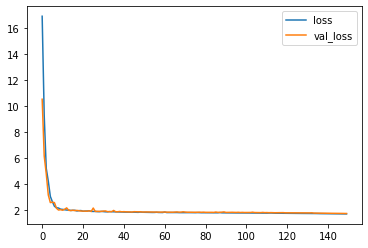

In [22]:
x = list(range(n_epoch))
plt.plot(x, history.history['loss'],label="loss")
plt.plot(x, history.history['val_loss'],label="val_loss")
plt.legend();

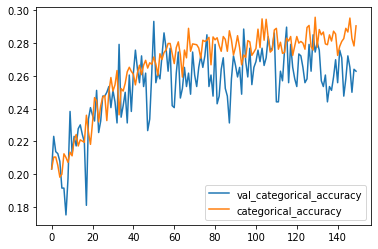

In [23]:
plt.plot(x, history.history['val_categorical_accuracy'],label="val_categorical_accuracy")
plt.plot(x, history.history['categorical_accuracy'],label="categorical_accuracy")
plt.legend();

In [26]:
x_test = features[test_num:]
y_test = dataset.label

In [68]:
label_to_activity = {0: 'DoS', 1: 'Fuzzy', 2: 'RPM',
                     3: 'gear', 4: 'Normal'}
activity_label = {'DoS':0, 'Fuzzy':1, 'RPM':2,
                     'gear':3, 'Normal':4}

In [69]:
list(label_to_activity.values())

['DoS', 'Fuzzy', 'RPM', 'gear', 'Normal']

In [70]:
def analyse_model_predictions(action_num):
    
    # Show the accelerometer data
    print('------------------------------')
    print('Accelerometer data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_test[action_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('True Event:', y_test[action_num])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 5))
    for i in range(200):
        predicted_probabilities[i] = model(x_test[action_num][np.newaxis, ...]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(5)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(5)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(5), pct_97p5, color='red')
    ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],
                       rotation=45, horizontalalignment='right')
    
    
#     bar[activity_label[y_test[action_num]]].set_color('green')
#     bar = ax.bar(np.arange(5), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')

    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

------------------------------
Accelerometer data:


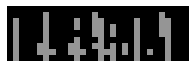

------------------------------
True Event: dos

------------------------------
Model estimated probabilities:


/tmp/ipykernel_10142/1397705333.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],


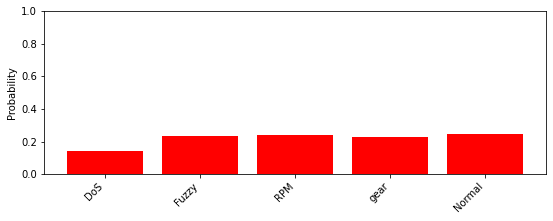

In [71]:
analyse_model_predictions(1)